# Lec 17. Bag of Words - Sentiment Analysis

In [1]:
import codecs
import pandas as pd
import numpy as np
import random

from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn.init
import torch.utils.data as data_utils

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [3]:
f = codecs.open("data/reviews.txt", 'r', 'utf-8')
f.read()[:1000]

'# G마켓에 좋은 평만 있어서 사봤는데.. 정말 진짜 진짜 사지마세요. 개. 쓰. 레. 기 (진심) 입니다. 액정부터 짜증나는 TN패널에, 하드 SSD인걸로 알았는데, 속도는 저질 SD카드 꽂아 놓은것 같습니다. 정말 느려터집니다. 저는 단지 인터넷 뱅킹만 할려고, 샀단 말입니다. 그런데 인터넷 뱅킹 프로그램까는데만 10~20분 걸립니다. 뭐약!! 이게!! 분노로 인해 볼때마다 짜증납니다. 밤에 잠도 안오고요.. 사시면 분명 후회하실겁니다. 아! 진짜 G마켓 프리미엄평으로 실날하게 사진찍어서 올리려고했는데, 먹고 산다고 바빠서 프리미엄 평 못 올린게 정말 천추의 한이네요!!\n# 원래 그런 줄 알고 사는 "저가 제품"이라고 생각합니다만. IPS라는 언급이 없으니 당연히 TN 패널일 테고, EMMC는 SSD가 아니고 SD 카드 내장된 것 같은 것이라 원래 SSD보다 느린 것이고, CPU도 아톰이니 뭐 당연히 느리죠. 그런 것 다 감안하고 "싸고 가볍다"는 조건으로 사는 제품인데요. 뭐 다만 얼만큼 액정 품질이 안 좋은지는 모르겠습니다. TN이라도 품질 등급이 있어서요.\n# 그러다 조x스토킹 당합니다\n# 음? 960g? LG GR...읍\n# 발열은 어떤가요?ㅠㅠ\n# Z3735니 크게 걱정될 수준이 아닐 것으로 보입니다. 동일CPU사용한 태블릿도 풀로드 60도도 넘기는걸 보기 힘든데, 이와 비슷하거나 더 낮지 않을까 싶네요.\n# 무게 960g아닙니다. 갖고있던 그램과 비교햇을 때 훨씬 무거워서 혹시나 해서 전자저울로 측정해봤더니... 1대는 1075g, 나머지 한대는 1090g 바로 환불했습니다... -_-\n# 그제 구입하여 사용중에 있습니다. eMMC하고 아톰이야 각오하고 구매하였으니 큰 문제 없는데..... 액정이 정말 쉣스럽네요 -ㅅ-;; 20만원대 다른 노트북을 사용해 본적이 없어서 비교는 되지 못합니다만, 이것 저것 건드려봐도 개선이 안되는게 근본적으로 글러먹은 액정입니다. 무게도 디자인도 잘 뽑아 놓고 이런데서 원가 절감을 해서 상품성을 떨어

## Extract Setences

In [4]:
# 원하는 리뷰만 추출하기

keywords = ["발열", "소음"]

for keyword in keywords :
    temp_list = []
    save_name = "data/reviews_" + keyword + ".txt"
    f = codecs.open("data/reviews.txt", 'r', 'utf-8')
    t = codecs.open(save_name, 'w', 'utf-8')
    
    while True:
        line = f.readline()
        if not line: break
        if keyword in line :
            temp_list.append(line)
            
    set_list = list(set(temp_list))
    
    for item in set_list :
        t.write(item)
        
    f.close()
    t.close()

In [5]:
f = codecs.open("data/reviews_발열.txt", 'r', 'utf-8')
f.read()[:500]

'# 좋은가격에 좋은 제품 구매했습니다.스펙이 더 좋은 게이밍 노트북도 시중에 많지만 발열우려와 무게 때문에 이제품을 선택했는데 탁월한 선택이었던 것 같습니다. 디자인도 이쁘고 마음에 듭니다.\n# 가성비 최곱니다. win10작업시 정말 빠릅니다. 정말 강추입니다. 그리고 가장 훌륭한건 디자인 팬소리는 다소 크지만 고성능 그래픽 장착이니 충분히 감수할수 있습니다. 노트북에 가장 큰 단점이 발열인데 전혀 없습니다. 만족스러운 제품 입니다. cpu 7세대 i7 이걸로 동종 모델들 다 잠제우기에 부족함이 없\n# 금요일 오후 4시 넘어서 주문했는데 토요일 오전에 도착했어요 배송속도는 확실합니다~^^컴퓨터 사양은 모든 면에서 뛰어납니다.다들 알아보시고 구매를 진행하시겠지만 제가 사용하는 사진편집,인터넷 작업, 간단한 게임?등에서 전혀 문제가 되지 않습니다.소음은 켜논지 모를 정도로 조용하네요제가 소음에는 좀 민감한편인데 선풍기 소리보다 조용해요발열도 하루에 10시간 이상씩 작업을 진행하는데 본체'

In [6]:
f = codecs.open("data/reviews_소음.txt", 'r', 'utf-8')
f.read()[:500]

'# 총평: 하직 몇시간 밖에 사용해보지 않았지만 현재 구매가격으로는 충분히 살만하다고 생각한다. 지인들에게 추천을 해줄수 있을 정도. 소음은 화이트노이즈(치~~)하는 팬소음이 난다. 풀로드시에도 팬소음은 나쁘진 않지만 전투기소리가 아니라 치~~하는 소리가 나기때문에 주위 사람들이 듣기에는 스피커에서 잡음 들리는것 같다. 스피커에서 소리가 나면 팬소리는 안들린다. 성능은 디아블로3를 해봤다. 하는 게임이 디아3 스카이림 뿐이라... 디아3도 은근 애먹이는 게임이라고 생각한다. 560ti인 필자 데스크탑은 100도를 가볍게 찍기때\n# 금요일 오후 4시 넘어서 주문했는데 토요일 오전에 도착했어요 배송속도는 확실합니다~^^컴퓨터 사양은 모든 면에서 뛰어납니다.다들 알아보시고 구매를 진행하시겠지만 제가 사용하는 사진편집,인터넷 작업, 간단한 게임?등에서 전혀 문제가 되지 않습니다.소음은 켜논지 모를 정도로 조용하네요제가 소음에는 좀 민감한편인데 선풍기 소리보다 조용해요발열도 하루에 10시간 '

## Loading Scored Data

In [7]:
# 키워드로 추출한 각 리뷰에 대해 score table 작성 필요...!!!

filename = "data/score_발열.xlsx"
sheet_name = "Sheet1"
data = pd.read_excel(filename, sheet_name = sheet_name, header = 0)
data.head()

,Review,Score
0,# 발열히 심한거 같은데 여름이라 그런가?..,2
1,# 발열이좀 심한거 같아서 걱정이에요,2
2,# 발열이심하더라구요,2
3,# 발열이너무심한게 제일큰 단점인것 같고 그외에 불편한점은,2
4,# 발열이...정말...심합니다,2


In [8]:
csv_data = [item.replace("#", "").strip() for item in data['Review']]
csv_label = data['Score']
len(csv_data)

1211

In [9]:
csv_data[:5]

['발열히 심한거 같은데 여름이라 그런가?..',
 '발열이좀 심한거 같아서 걱정이에요',
 '발열이심하더라구요',
 '발열이너무심한게 제일큰 단점인것 같고 그외에 불편한점은',
 '발열이...정말...심합니다']

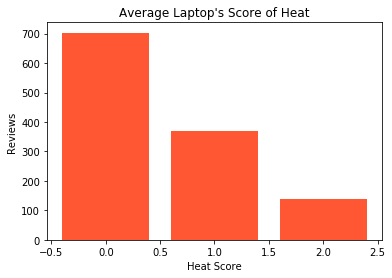

In [10]:
scores = [sum(csv_label == 0), sum(csv_label == 1), sum(csv_label == 2)]
plt.bar(range(len(scores)), scores, color="#ff5733")

plt.title("Average Laptop's Score of Heat")
plt.xlabel("Heat Score")
plt.ylabel("Reviews")
plt.show()

## Bag of Words

In [11]:
twitter = Okt()
doc = []

for sentence in csv_data :
    results= []
    tokens = twitter.pos(sentence, norm=True, stem=True)     # normalization, stemming 처리.
        
    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:  # 조사, 문장부호 등 제거.
            results.append(token[0])
            
    doc.append(" ".join(results).strip())
    
len(doc)

1211

In [12]:
doc[:5]

['발열 히 심하다 같다 여름 그 런가',
 '발열 이 좀 심하다 같다 걱정',
 '발열 심하다',
 '발열 이 너 무심하다 제일 크다 단점 것 같다 그 외 불편하다 점',
 '발열 정말 심하다']

In [13]:
# CountVectorizer
cv = CountVectorizer(ngram_range=(1,1), min_df = 3)

data = cv.fit_transform(doc).toarray()
label = csv_label.values

data[0]  # bag of words = one-hot encoding

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [14]:
cv.vocabulary_

{'100': 0,
 '50': 1,
 '70': 2,
 'as': 3,
 'cpu': 4,
 'ips': 5,
 'ssd': 6,
 'ㅜㅜ': 7,
 '가격': 8,
 '가다': 9,
 '가볍다': 10,
 '가성': 11,
 '감다': 12,
 '같다': 13,
 '개선': 14,
 '거의': 15,
 '걱정': 16,
 '걸리다': 17,
 '게임': 18,
 '겨울': 19,
 '고민': 20,
 '관리': 21,
 '괜찮다': 22,
 '굉장하다': 23,
 '구매': 24,
 '구성': 25,
 '그냥': 26,
 '그래도': 27,
 '그래픽': 28,
 '그램': 29,
 '그렇게': 30,
 '그렇다': 31,
 '그리다': 32,
 '기능': 33,
 '기다': 34,
 '기본': 35,
 '깔끔하다': 36,
 '끊기다': 37,
 '나다': 38,
 '나쁘다': 39,
 '나오다': 40,
 '낮다': 41,
 '내다': 42,
 '너무': 43,
 '노트': 44,
 '노트북': 45,
 '놀라다': 46,
 '높다': 47,
 '느껴지다': 48,
 '느끼다': 49,
 '느낌': 50,
 '느리다': 51,
 '늘다': 52,
 '능력': 53,
 '다니다': 54,
 '다른': 55,
 '다소': 56,
 '단점': 57,
 '대다': 58,
 '대단하다': 59,
 '대비': 60,
 '던지다': 61,
 '데스크탑': 62,
 '돌다': 63,
 '돌리다': 64,
 '돌아가다': 65,
 '돼다': 66,
 '되다': 67,
 '되어다': 68,
 '두다': 69,
 '뒤틀리다': 70,
 '들다': 71,
 '듭니': 72,
 '등등': 73,
 '디자인': 74,
 '따다': 75,
 '따뜻하다': 76,
 '따르다': 77,
 '딱하다': 78,
 '때문': 79,
 '떨어지다': 80,
 '또한': 81,
 '뛰어나다': 82,
 '뜨겁다': 83,
 '뜨다': 84,
 '라면': 85,
 '레노버': 86,
 '마감'

## Train/Test Spilt

In [15]:
dim = len(cv.vocabulary_)  # 벡터의 수
dim

295

In [16]:
train_data, test_data, train_label, test_label = train_test_split(data, label, stratify = label)

print(len(train_data))
print(len(test_data))

908
303


In [17]:
x = torch.from_numpy(train_data).type(torch.FloatTensor)
y = torch.from_numpy(train_label).type(torch.LongTensor)

y.size(), x.size()

(torch.Size([908]), torch.Size([908, 295]))

In [18]:
train_data = data_utils.TensorDataset(x, y)

batch_size = 10

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1,
                                           drop_last = True)

## Define Model for Sentiment Analysis

In [19]:
# DNN
linear1 = torch.nn.Linear(dim, 200, bias = True)
relu    = torch.nn.ReLU()
linear2 = torch.nn.Linear(200, 3, bias = True)

model = torch.nn.Sequential(linear1, relu, linear2)

In [20]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 10

In [22]:
for epoch in range(num_epochs):
    avg_cost = 0
    total_batch = len(train_data) // batch_size
    
    for i, (batch_text, batch_labels) in enumerate(train_loader):
        
        X = batch_text.view(-1, dim)
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
            
print("Learning Finished!")

Epoch [1/10], lter [90/90] Loss: 0.6076
Epoch [2/10], lter [90/90] Loss: 0.5681
Epoch [3/10], lter [90/90] Loss: 0.6890
Epoch [4/10], lter [90/90] Loss: 0.4091
Epoch [5/10], lter [90/90] Loss: 0.2973
Epoch [6/10], lter [90/90] Loss: 0.1957
Epoch [7/10], lter [90/90] Loss: 0.0384
Epoch [8/10], lter [90/90] Loss: 0.0651
Epoch [9/10], lter [90/90] Loss: 0.2338
Epoch [10/10], lter [90/90] Loss: 0.1898
Learning Finished!


## Test Model

In [23]:
x_test = torch.from_numpy(test_data).type(torch.FloatTensor)
y_test = torch.from_numpy(test_label).type(torch.LongTensor)

test_data = data_utils.TensorDataset(x, y)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1,
                                          shuffle=True)

In [24]:
model.eval()

correct = 0
total = 0

for text, labels in test_loader:
    
    text = text.view(-1, dim)
    outputs = model(text)
    
    _, pred = torch.max(outputs.data, 1)
    total += 1
    correct += (pred == labels).sum()
    
correct = correct.cpu().numpy()    
print('correct :', correct)
print('total   :', total)
print('Accuracy of test images: %f' % (100 * correct / total))

correct : 879
total   : 908
Accuracy of test images: 96.806167


## 17.8 Test Sentence

In [25]:
def IsItHot(string) :
    
    results= []
    tokens = twitter.pos(string, norm=True, stem=True)

    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
   
    sample = cv.transform([" ".join(results).strip()]).toarray()
    sample = torch.from_numpy(sample).type(torch.FloatTensor)
    res = torch.max(model(sample).data, 1)[1].numpy()
    
    if res == 0 : 
        print("분석 결과 : 발열 거의 없음")
    elif res == 1 :
        print("분석 결과 : 발열 조금 있음")
    else :
        print("분석 결과 : 발열 매우 심함")

In [26]:
IsItHot("노트북이 너무 뜨거워요")

분석 결과 : 발열 매우 심함


In [27]:
IsItHot("발열을 잘 잡았네요")

분석 결과 : 발열 거의 없음


## TF-IDF Vectorizer

In [28]:
# TF-IDF Vectorizer
tfidv = TfidfVectorizer().fit(doc)
data = tfidv.transform(doc).toarray()

data[0]

# data = pd.DataFrame(data)
# data = (data - data.mean()) / (data.max() - data.min() + 1)

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
train_data, test_data, train_label, test_label = train_test_split(data, label, stratify = label)

x = torch.from_numpy(train_data).type(torch.FloatTensor)
y = torch.from_numpy(train_label).type(torch.LongTensor)

y.size() , x.size()

(torch.Size([908]), torch.Size([908, 1075]))

In [30]:
train_data = data_utils.TensorDataset(x, y)

batch_size = 10

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1,
                                           drop_last = True)

In [31]:
dim = (x.size()[1])
dim

1075

In [32]:
linear1 = torch.nn.Linear(dim, 200, bias = True)
linear2 = torch.nn.Linear(200, 3, bias = True)
relu = torch.nn.ReLU()

model = torch.nn.Sequential(linear1, relu, linear2)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
for epoch in range(num_epochs):
    avg_cost = 0
    total_batch = len(train_data) // batch_size
    
    for i, (batch_text, batch_labels) in enumerate(train_loader):
        
        X = batch_text.view(-1, dim)
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [90/90] Loss: 0.7820
Epoch [2/10], lter [90/90] Loss: 0.3521
Epoch [3/10], lter [90/90] Loss: 0.4585
Epoch [4/10], lter [90/90] Loss: 0.1185
Epoch [5/10], lter [90/90] Loss: 0.3626
Epoch [6/10], lter [90/90] Loss: 0.0844
Epoch [7/10], lter [90/90] Loss: 0.1326
Epoch [8/10], lter [90/90] Loss: 0.1075
Epoch [9/10], lter [90/90] Loss: 0.0883
Epoch [10/10], lter [90/90] Loss: 0.0313
Learning Finished!


In [34]:
x_test = torch.from_numpy(test_data).type(torch.FloatTensor)
y_test = torch.from_numpy(test_label).type(torch.LongTensor)

test_data = data_utils.TensorDataset(x, y)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1,
                                          shuffle=True)

In [35]:
model.eval()

correct = 0
total = 0

for text, labels in test_loader:
    
    text = text.view(-1, dim)
    outputs = model(text)
    
    _, pred = torch.max(outputs.data, 1)
    total += 1
    correct += (pred == labels).sum()
    
correct = correct.cpu().numpy()    
print('correct :', correct)
print('total   :', total)
print('Accuracy of test images: %f' % (100 * correct / total))

correct : 900
total   : 908
Accuracy of test images: 99.118943
